# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import gc
import datetime
from copy import deepcopy
import cv2
import numpy as np
from IPython.display import clear_output

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from unet import PConvUnet
from util import random_mask

%matplotlib inline
%load_ext autoreload
%autoreload 2

# SETTINGS
TRAIN_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\train\ILSVRC2013_train\\"
TEST_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\train\ILSVRC2013_train\\"

BATCH_SIZE = 4

Using TensorFlow backend.


# Creating train & test data generator

In [3]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(512, 512), batch_size=BATCH_SIZE
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

Found 288661 images belonging to 569 classes.


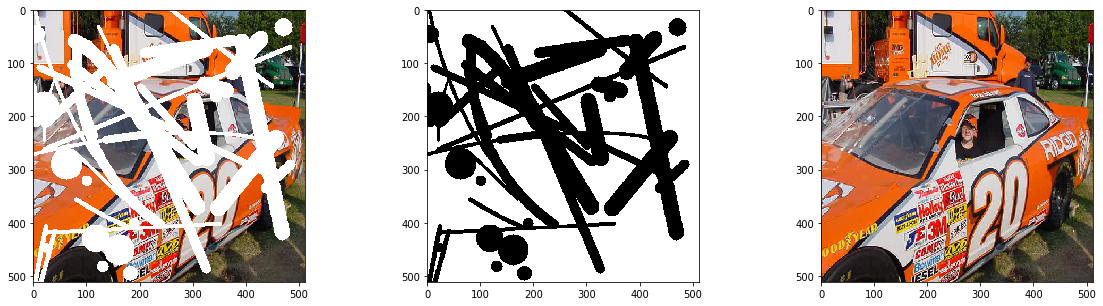

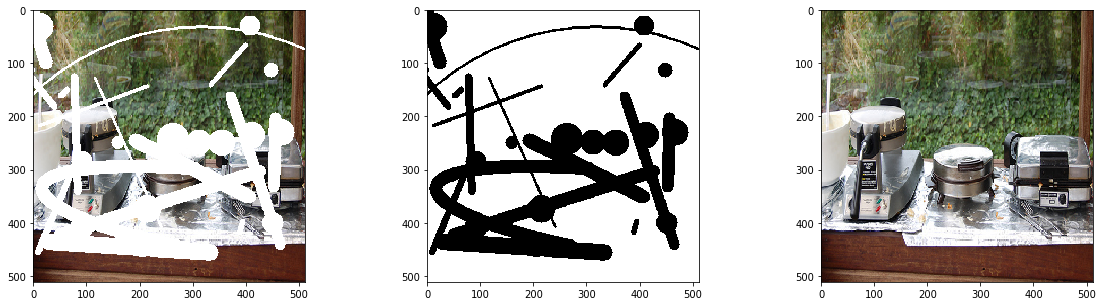

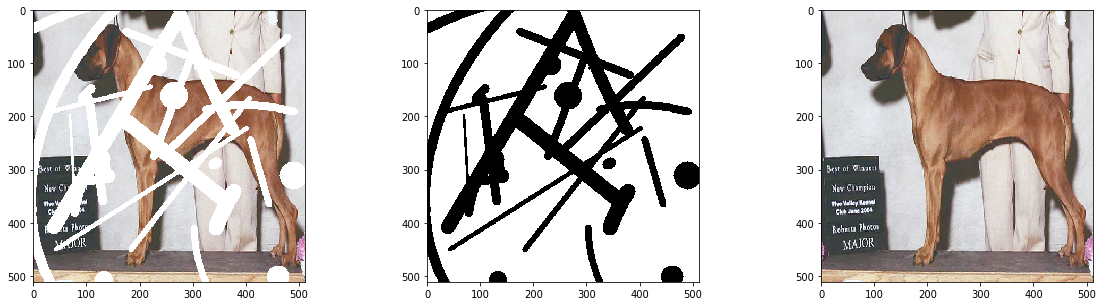

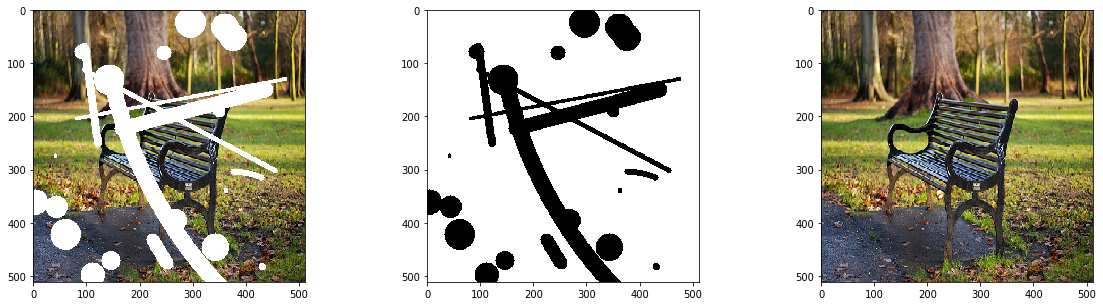

In [4]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Train the neural network

In [5]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    clear_output()
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'../data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.show()

In [ ]:
# Instantiate the model
model = PConvUnet()

# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=1000,
    epochs=10,        
    workers=2,
    plot_callback=plot_callback
)

>> Now creating Partial Conv U-Net Model
>> Fitting epoch 1
Epoch 1/1
Found 288661 images belonging to 569 classes.
 117/1000 [==>...........................] - ETA: 11:05 - loss: 1746776.9135